In [2]:
# Import libraries
import sqlite3 as sql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [3]:
con=sql.connect("./data/paperdb.db")
input_period=90
predication_period=1

In [4]:
SQL_BTC_USD_TRAIN = """
select * from BTC_USD where date>='2019-01-04'  order by date asc
"""
btc_usd = pd.read_sql(SQL_BTC_USD_TRAIN, con)

In [5]:
#btc_usd.head()


In [6]:
btc_usd.Timestamp = pd.to_datetime(btc_usd.date)
# Resampling to daily frequency
btc_usd.index = btc_usd.Timestamp
btc_usd = btc_usd.resample('D').mean()


In [7]:
#btc_usd[btc_usd.index>='2021-01-01'].close

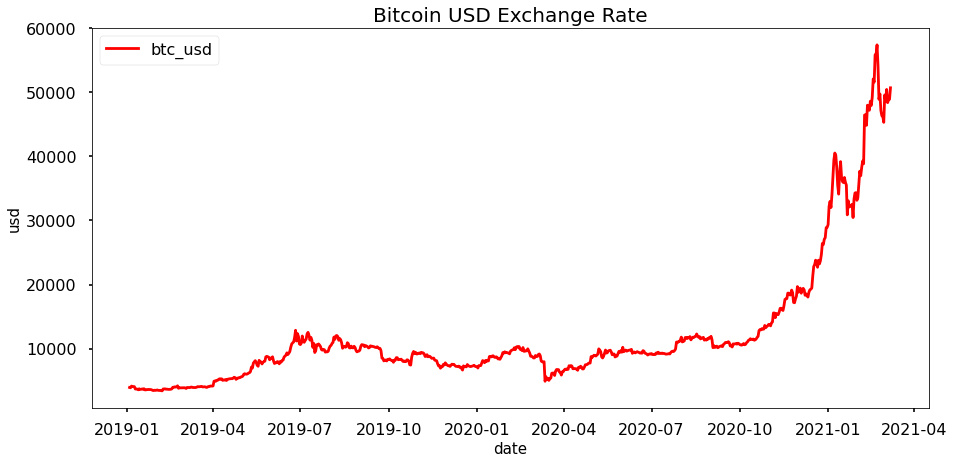

In [8]:
plt.figure(figsize=(15,7))

plt.plot(btc_usd.close, '-r', label='btc_usd')

plt.title("Bitcoin USD Exchange Rate", fontsize=20)
plt.xlabel("date", fontsize=15)
plt.ylabel("usd", fontsize=15)
plt.legend()
plt.show()

*** sm.tsa.stattools.adfuller used to do data stationary check
*** ARIMA asume data are stationary. If data is not stationary, we need do some pre-processing first to make data become stationary. 
*** Dickey–Fuller Test, p=0 means stationary. p=1 means not stationary.

Dickey–Fuller test: p=1.000000


<Figure size 1080x504 with 0 Axes>

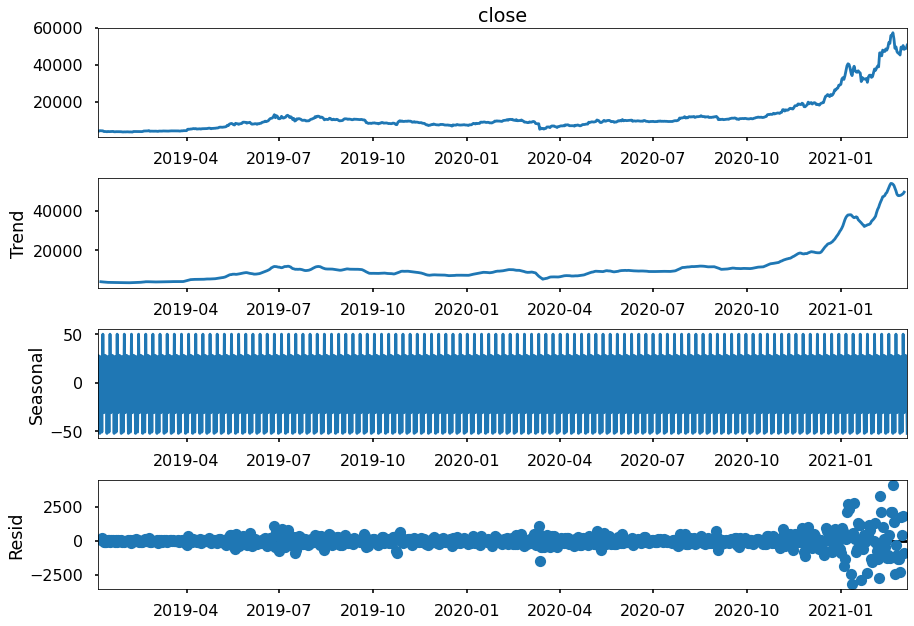

In [9]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(btc_usd.close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_usd.close)[1])
plt.show()

p=1.000000, hence the data is not stationary.
The seasonal components is trival compare to the residual. so we will consider this time series data have no seasonal components.

boxcox tranformation first. then do a DF test again.

In [10]:
btc_usd['trans_close'], lmbda = stats.boxcox(btc_usd.close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_usd.trans_close)[1])

Dickey–Fuller test: p=0.890227


In [11]:

print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_usd.trans_close)[1])


Dickey–Fuller test: p=0.890227


Not stationary. do a diffrence.

In [12]:
btc_usd['trans_close_diff'] = btc_usd.trans_close - btc_usd.trans_close.shift(1)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(btc_usd.trans_close_diff[1:])[1])

Dickey–Fuller test: p=0.000000


Now it is stationary. d=1

Search parameters:

In [15]:

def search_model(time_serial_data):
    qs = range(0, 3)
    ps = range(0, 3)
    d=1
    parameters = product(ps, qs)
    parameters_list = list(parameters)
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')
    for param in parameters_list:
        try:
            model=sm.tsa.statespace.SARIMAX(time_serial_data, order=(param[0], d, param[1])).fit(disp=-1)
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    return best_model

In [16]:
best_model = search_model(btc_usd.trans_close)

In [17]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [18]:
time_serial_data = btc_usd.close
model = best_model 

In [19]:
time_serial_data.index

DatetimeIndex(['2019-01-04', '2019-01-05', '2019-01-06', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-12', '2019-01-13',
               ...
               '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2021-03-06', '2021-03-07'],
              dtype='datetime64[ns]', name='date', length=794, freq='D')

In [20]:
# invboxcox(best_model.predict(start='2021-03-03', end='2021-03-03'), lmbda)
def predicate_next(model, next_date, lmbda):
    return invboxcox(model.predict(start=next_date, end=next_date), lmbda)

In [21]:
# Prediction
def train_model(time_serial_data):
    '''
    time_serial_data
    '''
    ### iterate below to predicate 30 days. 
    trans_close, lmbda = stats.boxcox(time_serial_data)
    model = search_model(trans_close)
    return model, lmbda


In [22]:
start_date='2021-01-11'
prdec = []
actual= []
for i in range(45):
    cur = (datetime.datetime.strptime(start_date,'%Y-%m-%d') + datetime.timedelta(days=i)).strftime("%Y-%m-%d")
    cur_next = (datetime.datetime.strptime(start_date,'%Y-%m-%d') + datetime.timedelta(days=i+1)).strftime("%Y-%m-%d")
    length = len(btc_usd[btc_usd.index<=cur].close)
    print(i, cur)
    newModel, lbd = train_model(btc_usd[btc_usd.index<=cur].close)
    acc= btc_usd[btc_usd.index==cur_next].close.values[0]
    prr = invboxcox(newModel.predict(start=length, end=length), lbd)
    actual.append(acc)
    prdec.append(prr[0])
    print(acc, prr[0])

0 2021-01-11
34103.0 35662.95883729065
1 2021-01-12
37375.0 34146.99989837034
2 2021-01-13
39170.0 36994.955410775816
3 2021-01-14
36741.0 39187.05231173536
4 2021-01-15
36055.0 36984.541262912724
5 2021-01-16
35903.0 36009.98904509254
6 2021-01-17
36699.0 35941.185856096585
7 2021-01-18
35958.0 36593.78743948823
8 2021-01-19
35521.1 36087.77400044139
9 2021-01-20
30873.0 35505.349210205735
10 2021-01-21
33062.0 31343.752295854927
11 2021-01-22
32099.0 32555.608270263692
12 2021-01-23
32298.0 32451.85963374553
13 2021-01-24
32268.1 32104.189991358326
14 2021-01-25
32519.0 32366.255716617292
15 2021-01-26
30454.0 32442.173489171713
16 2021-01-27
33331.0 30716.024496985538
17 2021-01-28
34280.7 32838.46018829876
18 2021-01-29
34334.0 34413.04383815934
19 2021-01-30
33141.0 34264.86205576019
20 2021-01-31
33559.0 33309.47242320499
21 2021-02-01
35563.0 33428.394152655455
22 2021-02-02
37677.0 35387.133389039205
23 2021-02-03
36975.0 37513.34788632217
24 2021-02-04
38260.0 37133.8838424527

In [23]:
def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    mse = skm.mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    error = rmse / len(actual)
   
    print('average RMSE:' , error)
    return error


In [24]:
def model_plot(actual, predict, name):
    '''
    该函数实现绘制RMSE曲线图
    '''
    plt.figure(figsize=(8,6), dpi=150)
    plt.plot(actual, marker='o', label="actual")
    plt.plot(predict, marker='x', label="predicated")
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$Price$', size=15)
    plt.title('ARIMA Bitcoin Predication Result',  size=18)
    plt.legend()
    plt.show()

In [26]:
import sklearn.metrics as skm
import math

In [27]:
evaluate_forecasts(prdec,actual)

average RMSE: 50.20704000650999


50.20704000650999

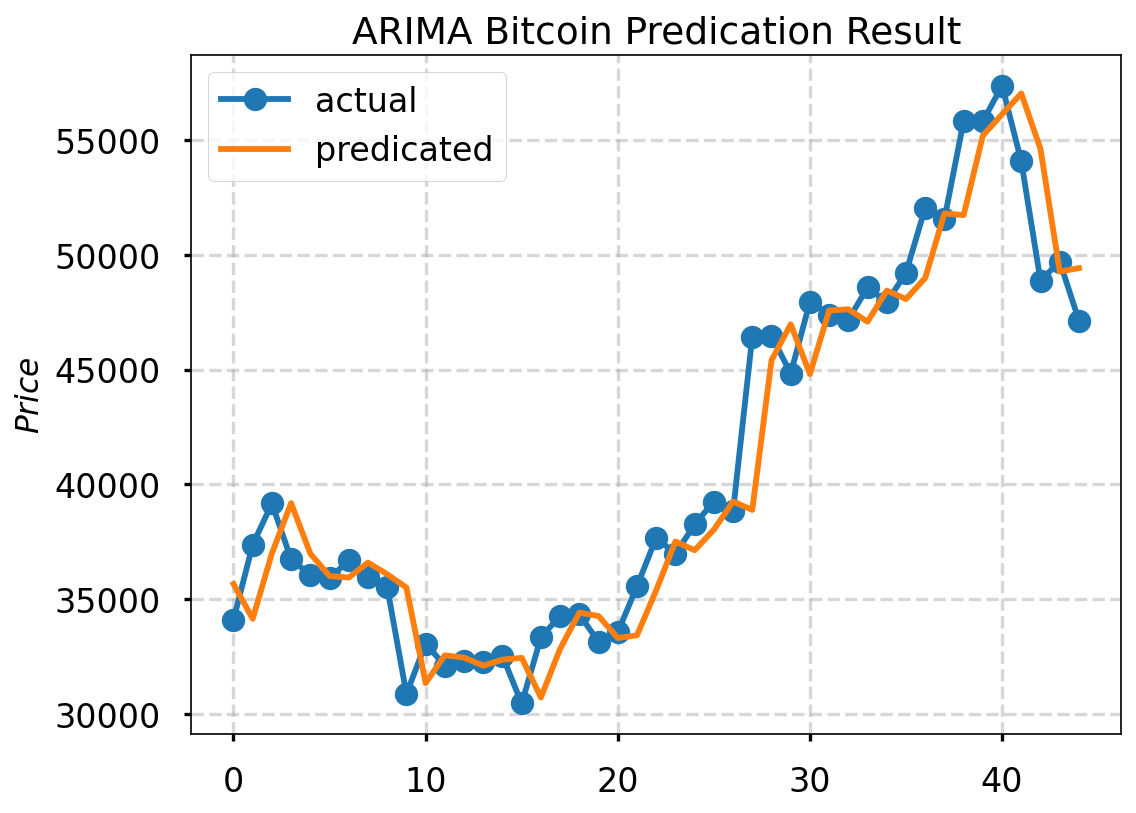

In [28]:
model_plot(actual, prdec, "test")